# Поиск оптимальных гиперпараметров

##### Автор: Виктор Китов ([DeepMachineLearning.ru](https://deepmachinelearning.ru))

##### Лицензия: BSD-3-Clause

Точность методов машинного обучения существенно зависят от выбора **гиперпараметров**, которые управляют самим процессом обучения. Они находятся перебором вариантов на отдельной валидационной выборке или с помощью кросс-валидации.

В этом ноутбуке на примере гиперпараметров `C` и `gamma` метода опорных векторов с гауссовым ядром мы рассмотрим и сравним три популярные стратегии перебора гиперпараметров, реализованные в библиотеке `scikit-learn`:

- **GridSearch** — полный перебор по заданной сетке всех возможных комбинаций гиперпараметров.
- **RandomSearch** — случайный поиск по заданным распределениям значений гиперпараметров.
- **HalvingRandomSearchCV** — последовательный отбор кандидатов с использованием случайного поиска и постепенным увеличением ресурсов для наиболее перспективных комбинаций.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
from time import time
from scipy.stats import loguniform
import warnings
warnings.filterwarnings('ignore')

# Настройка стиля графиков
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['font.size'] = 12

# Генерация данных

Генерация датасета make_moons...


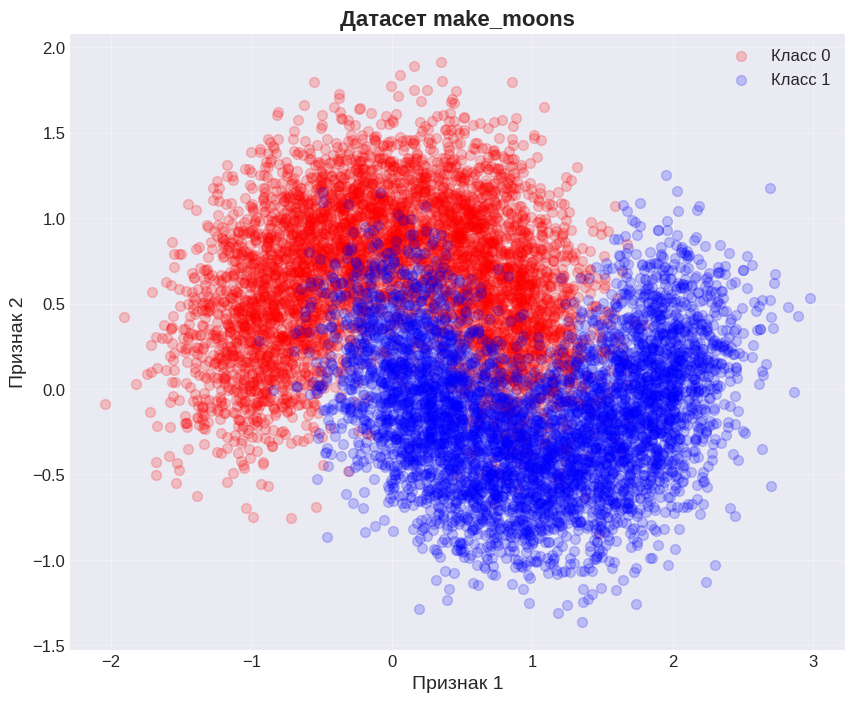

Размер данных: (10000, 2)
Количество объектов класса 0: 5000
Количество объектов класса 1: 5000


In [2]:
X, y = make_moons(n_samples=10000, noise=0.3, random_state=42)

# Визуализация данных
plt.figure(figsize=(10, 8))
plt.scatter(X[y == 0, 0], X[y == 0, 1], color='red', alpha=0.2, s=50, label='Класс 0')
plt.scatter(X[y == 1, 0], X[y == 1, 1], color='blue', alpha=0.2, s=50, label='Класс 1')
plt.title('Датасет make_moons', fontsize=16, fontweight='bold')
plt.xlabel('Признак 1', fontsize=14)
plt.ylabel('Признак 2', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

print(f"Размер данных: {X.shape}")
print(f"Количество объектов класса 0: {np.sum(y == 0)}")
print(f"Количество объектов класса 1: {np.sum(y == 1)}")

# ДЕМОНСТРАЦИЯ РАЗНЫХ ГИПЕРПАРАМЕТРОВ SVM

Обучающая выборка: (7000, 2)
Тестовая выборка: (3000, 2)

ДЕМОНСТРАЦИЯ РАЗНЫХ ГИПЕРПАРАМЕТРОВ SVM
Модель 1: C=0.1, gamma=0.1 → Accuracy = 0.8667
Модель 2: C=100, gamma=10 → Accuracy = 0.9237


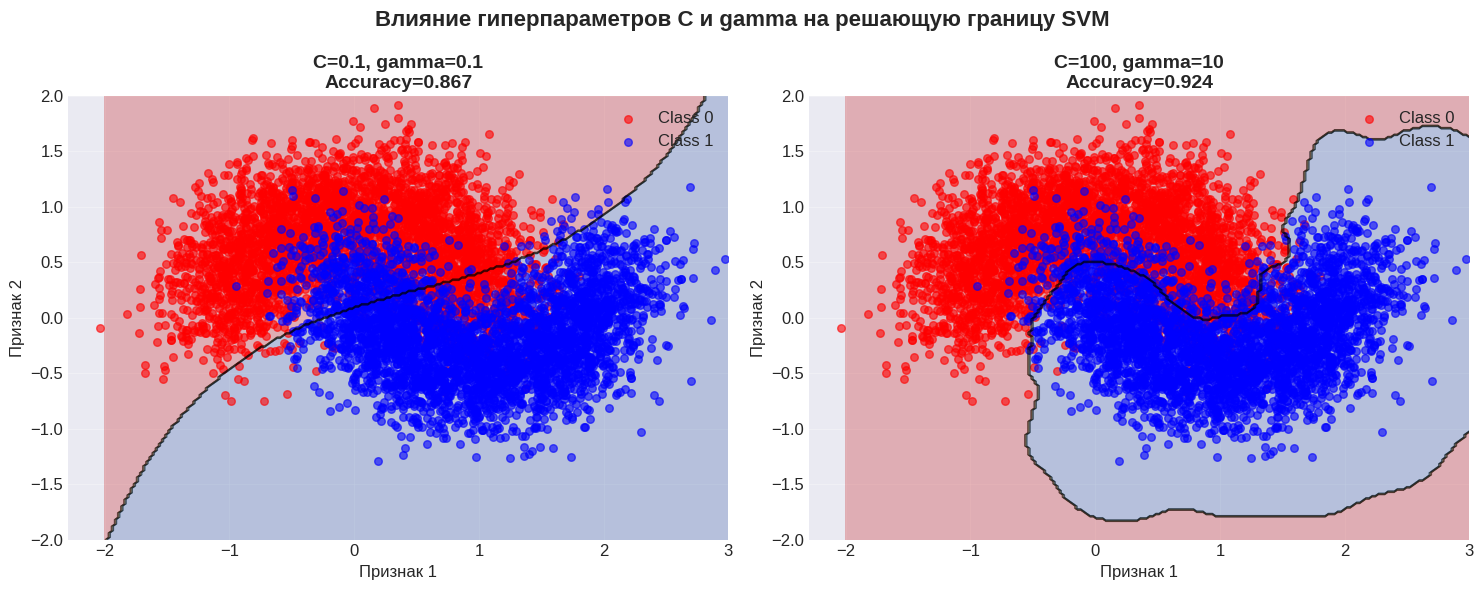


ЗАДАЧА: подобрать оптимальные C и gamma


In [3]:
# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Обучающая выборка: {X_train.shape}")
print(f"Тестовая выборка: {X_test.shape}")

# Пример 1: Маленькая C и gamma (простая модель)
svm1 = SVC(kernel='rbf', C=0.1, gamma=0.1, random_state=42)
svm1.fit(X_train, y_train)
y_pred1 = svm1.predict(X_test)
acc1 = accuracy_score(y_test, y_pred1)

# Пример 2: Большая C и gamma (сложная модель, может переобучаться)
svm2 = SVC(kernel='rbf', C=100, gamma=10, random_state=42)
svm2.fit(X_train, y_train)
y_pred2 = svm2.predict(X_test)
acc2 = accuracy_score(y_test, y_pred2)

print(f"Модель 1: C=0.1, gamma=0.1 → Accuracy = {acc1:.4f}")
print(f"Модель 2: C=100, gamma=10 → Accuracy = {acc2:.4f}")

# Визуализация решающих границ
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Создаем сетку для визуализации
xx, yy = np.meshgrid(np.linspace(-2, 3, 200), np.linspace(-2, 2, 200))
grid = np.c_[xx.ravel(), yy.ravel()]

for ax, model, title, acc in zip(axes, [svm1, svm2], 
                                 [f"C=0.1, gamma=0.1\nAccuracy={acc1:.3f}", 
                                  f"C=100, gamma=10\nAccuracy={acc2:.3f}"],
                                 [acc1, acc2]):
    
    # Прогноз для всей сетки
    Z = model.predict(grid)
    Z = Z.reshape(xx.shape)
    
    # Граница решения
    ax.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.RdYlBu)
    ax.contour(xx, yy, Z, colors='black', linewidths=0.5, alpha=0.5)
    
    # Обучающие точки
    ax.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], 
               color='red', alpha=0.6, s=30, label='Class 0')
    ax.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], 
               color='blue', alpha=0.6, s=30, label='Class 1')
    
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel('Признак 1')
    ax.set_ylabel('Признак 2')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle('Влияние гиперпараметров C и gamma на решающую границу SVM', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

### Наша задача - подобрать оптимальные C и gamma

# Метод `GridSearchCV`

### Он представляет собой полный перебор всех комбинаций отдельных гиперпараметров.

In [4]:
# Определяем сетку параметров для поиска 4x4
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.01, 0.1, 1, 10]
}

print(f"Сетка параметров:")
print(f"  C: {param_grid['C']}")
print(f"  gamma: {param_grid['gamma']}")
print(f"  Всего комбинаций: {len(param_grid['C']) * len(param_grid['gamma'])}")

Сетка параметров:
  C: [0.1, 1, 10, 100]
  gamma: [0.01, 0.1, 1, 10]
  Всего комбинаций: 16



GRIDSEARCHCV - ПОЛНЫЙ ПЕРЕБОР ВСЕХ КОМБИНАЦИЙ
Время выполнения: 1.81 секунд
Лучшие параметры: {'C': 1, 'gamma': 1}
Лучшая accuracy на кросс-валидации: 0.9150
Accuracy на тесте: 0.9250

Визуализация проверенных комбинаций параметров:


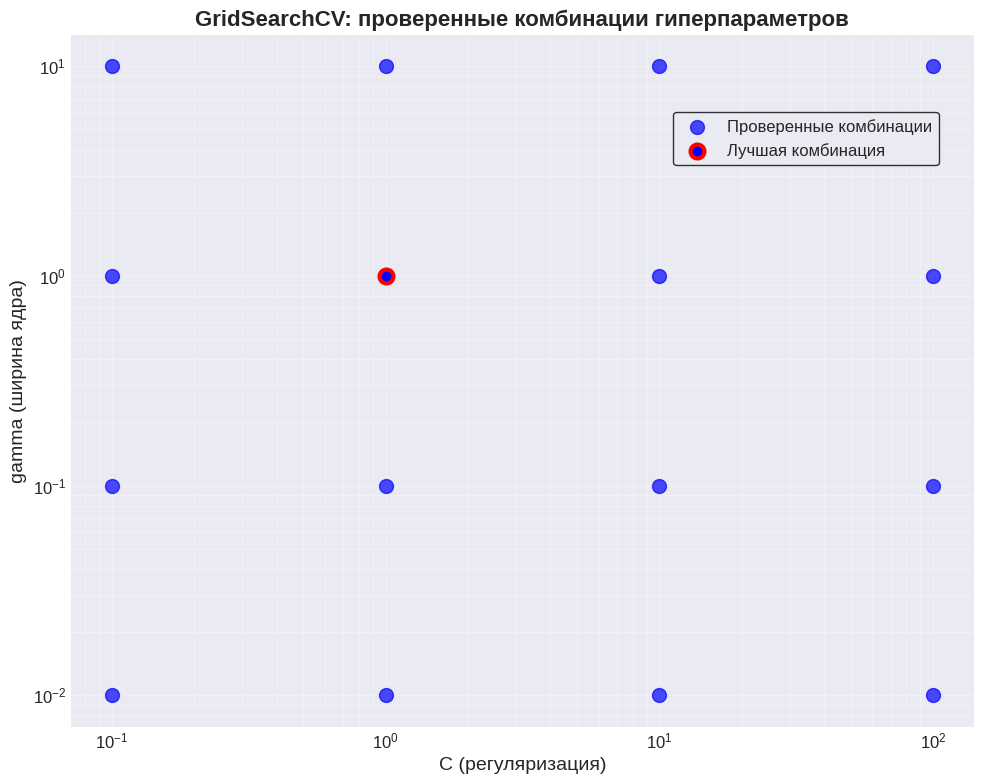

In [5]:
grid_search = GridSearchCV(
    SVC(kernel='rbf', random_state=42),
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=0
)

start_time = time()
grid_search.fit(X_train, y_train)
grid_time = time() - start_time

print(f"Время выполнения: {grid_time:.2f} секунд")
print(f"Лучшие параметры: {grid_search.best_params_}")
print(f"Лучшая accuracy на кросс-валидации: {grid_search.best_score_:.4f}")

# Оценка на тестовой выборке
y_pred_grid = grid_search.predict(X_test)
acc_grid = accuracy_score(y_test, y_pred_grid)
print(f"Accuracy на тесте: {acc_grid:.4f}")

# Визуализация всех проверенных комбинаций
print("\nВизуализация проверенных комбинаций параметров:")

# Преобразуем результаты в удобный формат
results = pd.DataFrame(grid_search.cv_results_)

# Визуализация
plt.figure(figsize=(10, 8))

# Все проверенные точки - синие шары
plt.scatter(results['param_C'], results['param_gamma'], 
           s=100, color='blue', alpha=0.7, label='Проверенные комбинации')

# Лучшая точка - синий шар с красной обводкой
best_C = grid_search.best_params_['C']
best_gamma = grid_search.best_params_['gamma']
plt.scatter(best_C, best_gamma, s=100, color='blue',
           edgecolor='red', linewidth=3, label='Лучшая комбинация')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('C (регуляризация)', fontsize=14)
plt.ylabel('gamma (ширина ядра)', fontsize=14)
plt.title('GridSearchCV: проверенные комбинации гиперпараметров', 
          fontsize=16, fontweight='bold')
plt.legend(fontsize=12, frameon=True, fancybox=True, framealpha=0.8, edgecolor='black', 
           loc='upper right', bbox_to_anchor=(0.97, 0.9))
plt.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

# Метод `RandomizedSearchCV`

### В нём отдельные гиперпараметры сэмплируются случайно из заданных распределений.


RANDOMIZEDSEARCHCV - СЛУЧАЙНЫЙ ПОИСК
Время выполнения: 0.57 секунд
Лучшие параметры: {'C': np.float64(15.702970884055382), 'gamma': np.float64(0.6251373574521749)}
Лучшая accuracy на кросс-валидации: 0.9150
Accuracy на тесте: 0.9240
Ускорение относительно GridSearch: 3.2x


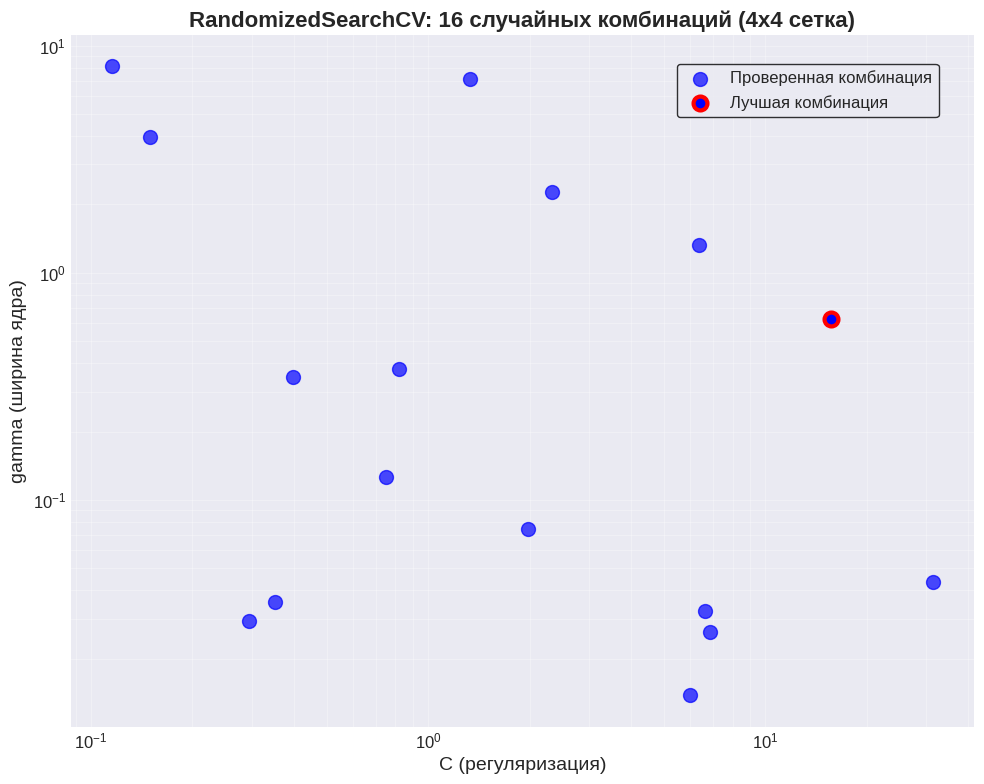

In [6]:

# Используем лог-равномерное распределение для C и gamma
# Адаптируем под новую сетку 4x4: C=[0.1, 1, 10, 100], gamma=[0.01, 0.1, 1, 10]
param_dist = {
    'C': loguniform(0.1, 100),     
    'gamma': loguniform(0.01, 10)  
}

# Используем то же количество оценок, что и в GridSearch (4x4 = 16 итераций)
n_iter = len(param_grid['C']) * len(param_grid['gamma'])  

random_search = RandomizedSearchCV(
    SVC(kernel='rbf', random_state=0),
    param_distributions=param_dist,
    n_iter=n_iter,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42,
    verbose=0
)

start_time = time()
random_search.fit(X_train, y_train)
random_time = time() - start_time

print(f"Время выполнения: {random_time:.2f} секунд")
print(f"Лучшие параметры: {random_search.best_params_}")
print(f"Лучшая accuracy на кросс-валидации: {random_search.best_score_:.4f}")

# Оценка на тестовой выборке
y_pred_random = random_search.predict(X_test)
acc_random = accuracy_score(y_test, y_pred_random)
print(f"Accuracy на тесте: {acc_random:.4f}")
print(f"Ускорение относительно GridSearch: {grid_time/random_time:.1f}x")

# Визуализация проверенных комбинаций
plt.figure(figsize=(10, 8))

# Все проверенные точки - только синие
params_list = random_search.cv_results_['params']
scores_list = random_search.cv_results_['mean_test_score']

# Рисуем все точки синим
C_vals = [p['C'] for p in params_list]
gamma_vals = [p['gamma'] for p in params_list]
plt.scatter(C_vals, gamma_vals, s=100, color='blue', alpha=0.7, label='Проверенная комбинация')

# Отдельно рисуем лучшую точку - красная обводка
best_C_rand = random_search.best_params_['C']
best_gamma_rand = random_search.best_params_['gamma']
plt.scatter(best_C_rand, best_gamma_rand, s=100, color='blue',
           edgecolor='red', linewidth=3, label='Лучшая комбинация')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('C (регуляризация)', fontsize=14)
plt.ylabel('gamma (ширина ядра)', fontsize=14)
plt.title(f'RandomizedSearchCV: {n_iter} случайных комбинаций (4x4 сетка)', 
          fontsize=16, fontweight='bold')
plt.legend(fontsize=12, frameon=True, fancybox=True, framealpha=0.8, edgecolor='black', 
           loc='upper right', bbox_to_anchor=(0.97, 0.97))
plt.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

# Метод `HalvingRandomSearchCV`

### В нём отдельные гиперпараметры сэмплируются независимо, а их отбор происходит в несколько раундов, на каждом из которых отбираются наименее перспективные комбинации, а моделям с оставшимися комбинациями гиперпараметров предоставляется дополнительный вычислительный ресурс для более точной настройки.

### Этот метод позволяет балансировать широту первоначального перебора из широкого спектра вариантов и более тщательное и точное сравнение перспективных комбинаций гиперпараметров на более поздних итерациях алгоритма.

In [7]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV


HALVINGRANDOMSEARCHCV - ОПТИМИЗИРОВАННЫЙ ДЛЯ СКОРОСТИ
Начинаем оптимизированный поиск с параметрами:
• Начальное количество кандидатов: 64
• Фактор уменьшения: 3 (оставляем 1/3 лучших)
• Минимальный ресурс: 50 объектов
• Максимальный ресурс: 2000 объектов
n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 50
max_resources_: 2000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 64
n_resources: 50
Fitting 3 folds for each of 64 candidates, totalling 192 fits
----------
iter: 1
n_candidates: 22
n_resources: 150
Fitting 3 folds for each of 22 candidates, totalling 66 fits
----------
iter: 2
n_candidates: 8
n_resources: 450
Fitting 3 folds for each of 8 candidates, totalling 24 fits
----------
iter: 3
n_candidates: 3
n_resources: 1350
Fitting 3 folds for each of 3 candidates, totalling 9 fits

HalvingRandomSearchCV (оптимизированный) завершён за 0.29 секунд
Лучшие параметры: {'C': np.float64(0.2647114182821816), 'gamma': np.float64(2.5

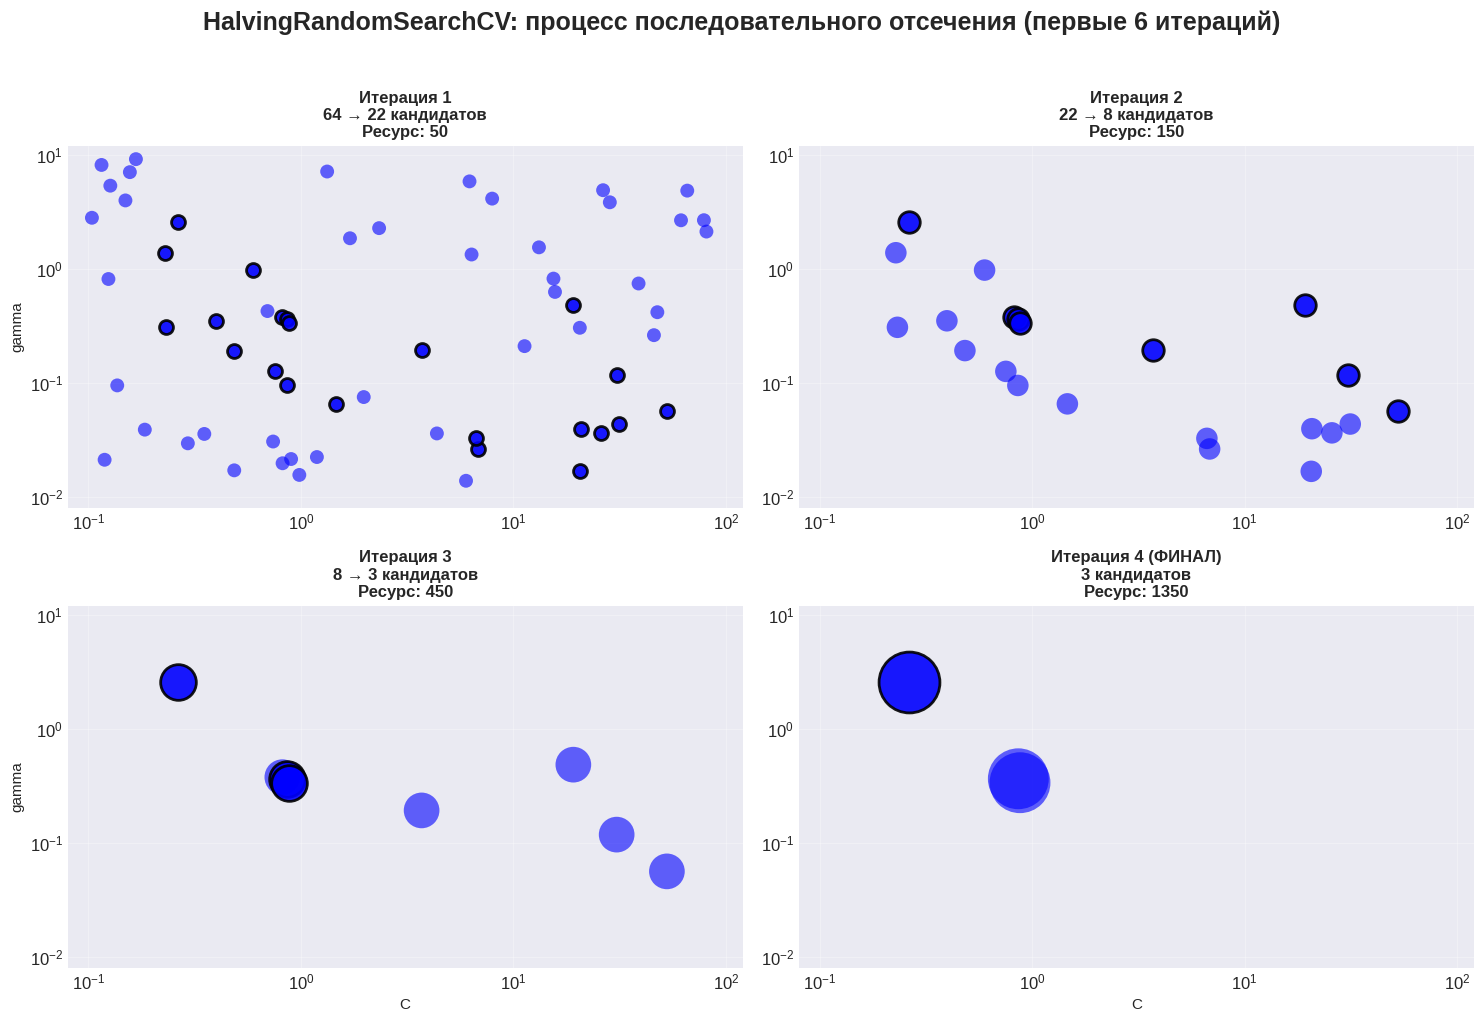


СВОДНАЯ ТАБЛИЦА СРАВНЕНИЯ МЕТОДОВ (ОПТИМИЗИРОВАННАЯ)
                Метод  Время (сек)  Accuracy  Всего оценок                 Описание  Ускорение
         GridSearchCV        1.813     0.925            16        4x4=16 комбинаций      1.000
   RandomizedSearchCV        0.569     0.924            16  16 случайных комбинаций      3.186
HalvingRandomSearchCV        0.294     0.926            97 4 итераций, начинал с 64      6.169


In [11]:
# HalvingRandomSearchCV - оптимизированный для скорости
print("\n" + "="*60)
print("HALVINGRANDOMSEARCHCV - ОПТИМИЗИРОВАННЫЙ ДЛЯ СКОРОСТИ")
print("="*60)

# Создаем оптимизированный HalvingRandomSearchCV
halving_random_search_fast = HalvingRandomSearchCV(
    estimator=SVC(kernel='rbf', random_state=0),
    param_distributions=param_dist,
    n_candidates=64,          # начинаем с 64 кандидатов
    factor=3,                 # уменьшать в 3 раза на каждой итерации (быстрее)
    min_resources=50,         # меньше объектов на первых итерациях
    max_resources=2000,       # ограничиваем максимальный ресурс
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

print(f"Начинаем оптимизированный поиск с параметрами:")
print(f"• Начальное количество кандидатов: 64")
print(f"• Фактор уменьшения: 3 (оставляем 1/3 лучших)")
print(f"• Минимальный ресурс: 50 объектов")
print(f"• Максимальный ресурс: 2000 объектов")

start_time = time()
halving_random_search_fast.fit(X_train, y_train)
halving_random_time_fast = time() - start_time

# Результаты
print(f"\nHalvingRandomSearchCV (оптимизированный) завершён за {halving_random_time_fast:.2f} секунд")
print(f"Лучшие параметры: {halving_random_search_fast.best_params_}")
print(f"Лучшая accuracy на кросс-валидации: {halving_random_search_fast.best_score_:.4f}")

# Оценка на тестовой выборке
y_pred_halving_random_fast = halving_random_search_fast.predict(X_test)
acc_halving_random_fast = accuracy_score(y_test, y_pred_halving_random_fast)
print(f"Accuracy на тесте: {acc_halving_random_fast:.4f}")

# Сравнение с другими методами
print(f"\nСравнение с другими методами:")
print(f"Ускорение относительно GridSearch: {grid_time/halving_random_time_fast:.1f}x")
print(f"Ускорение относительно RandomSearch: {random_time/halving_random_time_fast:.1f}x")

# Информация об итерациях
print(f"\nИнформация об итерациях:")
print(f"Количество итераций: {halving_random_search_fast.n_iterations_}")
for i in range(halving_random_search_fast.n_iterations_):
    print(f"  Итерация {i+1}: {halving_random_search_fast.n_candidates_[i]} кандидатов, "
          f"ресурс: {halving_random_search_fast.n_resources_[i]}")

# Визуализация проверенных комбинаций по итерациям
print("\nВизуализация процесса HalvingRandomSearchCV...")

# Определяем количество итераций для визуализации (максимум 6)
n_iterations_to_show = min(6, halving_random_search_fast.n_iterations_)
n_rows = 2
n_cols = 2

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))
fig.suptitle('HalvingRandomSearchCV: процесс последовательного отсечения (первые 6 итераций)', 
             fontsize=18, fontweight='bold', y=1.02)

# Собираем данные по итерациям из cv_results_
results_df = pd.DataFrame(halving_random_search_fast.cv_results_)

# Группируем по итерациям
results_df['iteration'] = results_df['iter']

for iteration in range(n_iterations_to_show):
    # Фильтруем результаты по итерации
    iteration_results = results_df[results_df['iteration'] == iteration]
    
    # Определяем позицию на сетке (2x3)
    row = iteration // n_cols
    col = iteration % n_cols
    
    ax = axes[row, col]
    
    if not iteration_results.empty:
        # Получаем кандидатов и их оценки для этой итерации
        params_list = iteration_results['params'].tolist()
        scores_list = iteration_results['mean_test_score'].tolist()
        
        # Рисуем всех кандидатов текущей итерации
        C_vals = [p['C'] for p in params_list]
        gamma_vals = [p['gamma'] for p in params_list]
        
        # Размер маркера пропорционален ресурсу итерации
        resource = halving_random_search_fast.n_resources_[iteration]
        base_size = 30 + (resource / halving_random_search_fast.n_resources_[0]) * 70
        
        # Находим лучший кандидат на этой итерации
        if iteration < halving_random_search_fast.n_iterations_ - 1:
            # Для не-финальных итераций - лучший это тот, что перешел на следующую
            next_iter_results = results_df[results_df['iteration'] == iteration + 1]
            if not next_iter_results.empty:
                next_params = next_iter_results['params'].tolist()
                survivors = next_params
            else:
                survivors = []
        else:
            # Для финальной итерации - лучший это winner
            survivors = [halving_random_search_fast.best_params_]
        
        # Рисуем всех кандидатов
        for C, gamma, score in zip(C_vals, gamma_vals, scores_list):
            # Определяем, выжил ли кандидат
            is_survivor = any(
                abs(p['C'] - C) < 1e-10 and abs(p['gamma'] - gamma) < 1e-10 
                for p in survivors
            )
            
            # Размер и цвет маркера
            marker_size = base_size
            
            if is_survivor:
                # Выжившие кандидаты - обводка черным
                edge_color = 'black'
                edge_width = 2
                alpha = 0.9
            else:
                # Невыжившие кандидаты
                edge_color = 'none'
                edge_width = 0.5
                alpha = 0.6
            
            ax.scatter(C, gamma, s=marker_size, 
                      color='blue', alpha=alpha, 
                      edgecolor=edge_color, linewidth=edge_width)
    
    # Настройки графика
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('C' if row == n_rows - 1 else '', fontsize=11)
    ax.set_ylabel('gamma' if col == 0 else '', fontsize=11)
    
    # Заголовок с информацией
    n_candidates = halving_random_search_fast.n_candidates_[iteration]
    resource = halving_random_search_fast.n_resources_[iteration]
    
    if iteration < halving_random_search_fast.n_iterations_ - 1:
        next_candidates = halving_random_search_fast.n_candidates_[iteration + 1]
        title = f"Итерация {iteration+1}\n{n_candidates} → {next_candidates} кандидатов\nРесурс: {resource}"
    else:
        title = f"Итерация {iteration+1} (ФИНАЛ)\n{n_candidates} кандидатов\nРесурс: {resource}"
    
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.set_xlim([0.08, 120])
    ax.set_ylim([0.008, 12])

# Скрываем лишние оси, если итераций меньше 6
for i in range(n_iterations_to_show, n_rows * n_cols):
    row = i // n_cols
    col = i % n_cols
    axes[row, col].set_visible(False)

plt.tight_layout()
plt.show()

# Сводная таблица сравнения методов
print("\n" + "="*60)
print("СВОДНАЯ ТАБЛИЦА СРАВНЕНИЯ МЕТОДОВ (ОПТИМИЗИРОВАННАЯ)")
print("="*60)

comparison_data = [
    ('GridSearchCV', grid_time, acc_grid, 
     len(param_grid['C']) * len(param_grid['gamma']), 
     '4x4=16 комбинаций'),
    ('RandomizedSearchCV', random_time, acc_random, 
     n_iter, 
     f'{n_iter} случайных комбинаций'),
    ('HalvingRandomSearchCV', halving_random_time_fast, acc_halving_random_fast, 
     sum(halving_random_search_fast.n_candidates_), 
     f'{halving_random_search_fast.n_iterations_} итераций, начинал с 64'),
]

comparison_df = pd.DataFrame(comparison_data, 
                            columns=['Метод', 'Время (сек)', 'Accuracy', 
                                    'Всего оценок', 'Описание'])

comparison_df['Ускорение'] = comparison_df['Время (сек)'].iloc[0] / comparison_df['Время (сек)']

print(comparison_df.round(3).to_string(index=False))